In [1]:
import pandas as pd
import utils
import matplotlib.pyplot as plt
import random
import plotly.express as px

random.seed(9000)

plt.style.use("seaborn-ticks")
plt.rcParams["image.cmap"] = "Set1"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
%matplotlib inline

In this notebook we calculate Percent Replicating to measure of the proportion of perturbations with detectable signature. The following are the steps taken

- Normalized, feature selected profiles are read and the replicate plates are merged into a single dataframe.
- Separate data frames are created for each concentration and all the following steps are repeated for each data frame
    - Negative control, Positive control and empty wells are removed from the dataframe.
    - The signal distribution, which is the median pairwise replicate correlation, is computed for each replicate.
    - The null distribution, which is the median pairwise correlation of non-replicates, is computed for 1000 combinations of non-replicates.
    - Percent Replicating is computed as the percentage of the signal distribution that is the greater than the 95th percentile of null distribution.
    - The signal and noise distributions and the Percent Replicating values are plotted and the table of Percent Replicating is printed.
- A single table with replicate correlations at both concentration is printed.
- Correlation values are plotted as bar plots


In [2]:
experiment_df = pd.read_csv('output/experiment-metadata.tsv', sep='\t')

corr_replicating_df = pd.DataFrame()
all_replicating_corr_df = pd.DataFrame()
group_by_feature = 'Metadata_broad_sample'
n_samples = 1000
n_replicates = 16

experiment_df.head()

,Batch,Plate_Map_Name,Assay_Plate_Barcode,Cell_Type
0,2021_04_07_Batch1,CR-12982_Gray_cmpds_AB00027680,BR00122970,PATU-8988T
1,2021_04_07_Batch1,CR-12982_Gray_cmpds_AB00027680,BR00122971,PATU-8988T
2,2021_04_07_Batch1,CR-12982_Gray_cmpds_AB00027680,BR00122972,MDA-MB-231
3,2021_04_07_Batch1,CR-12982_Gray_cmpds_AB00027680,BR00122973,MDA-MB-231
4,2021_04_07_Batch1,CR-12982_Gray_cmpds_AB00027680,BR00122974,U2OS


In [3]:
for i, cell_type in enumerate(experiment_df.Cell_Type.unique()):
    batch = experiment_df.loc[i, 'Batch']
    cell_type_df = experiment_df.query('Cell_Type==@cell_type')
    all_plates_df = pd.DataFrame()
    for plate in cell_type_df.Assay_Plate_Barcode.unique():
        df = (
            pd.read_csv(f'../profiles/{batch}/{plate}/{plate}_normalized_feature_select_negcon_batch.csv.gz', dtype={'Metadata_mmoles_per_liter':str})
            .assign(Metadata_sample=lambda x: x.Metadata_Supplier_Catalog+'_'+x.Metadata_mmoles_per_liter)
        )
        all_plates_df = utils.concat_profiles(all_plates_df, df)
    all_plates_df = utils.remove_all_control_empty_wells(all_plates_df)

    replicating_corr_df = utils.corr_between_replicates_df(all_plates_df, 'Metadata_sample')
    replicating_corr = list(replicating_corr_df.replicate_correlation)
    null_replicating = utils.corr_between_non_replicates(all_plates_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name='Metadata_sample')

    prop_95_replicating, value_95_replicating = utils.percent_score(null_replicating, replicating_corr, how='right')

    corr_replicating_df = corr_replicating_df.append({'Description':f'Cell Type={cell_type}',
                                                      'Replicating':replicating_corr,
                                                      'Null_Replicating':null_replicating,
                                                      'Percent_Replicating':'%.1f'%prop_95_replicating,
                                                      'Value_95':value_95_replicating}, ignore_index=True)

    replicating_corr_df['Cell_Type'] = f'{cell_type}'
    replicating_corr_df[['Metadata_Supplier_Catalog','Concentration']] = replicating_corr_df.Metadata_sample.str.split('_',expand=True)

    all_replicating_corr_df =  utils.concat_profiles(all_replicating_corr_df, replicating_corr_df)

In [4]:
print(corr_replicating_df[['Description', 'Percent_Replicating']].to_markdown(index=False))

| Description          |   Percent_Replicating |
|:---------------------|----------------------:|
| Cell Type=PATU-8988T |                  51.5 |
| Cell Type=MDA-MB-231 |                  57.6 |
| Cell Type=U2OS       |                  39.4 |
| Cell Type=A549       |                  66.7 |


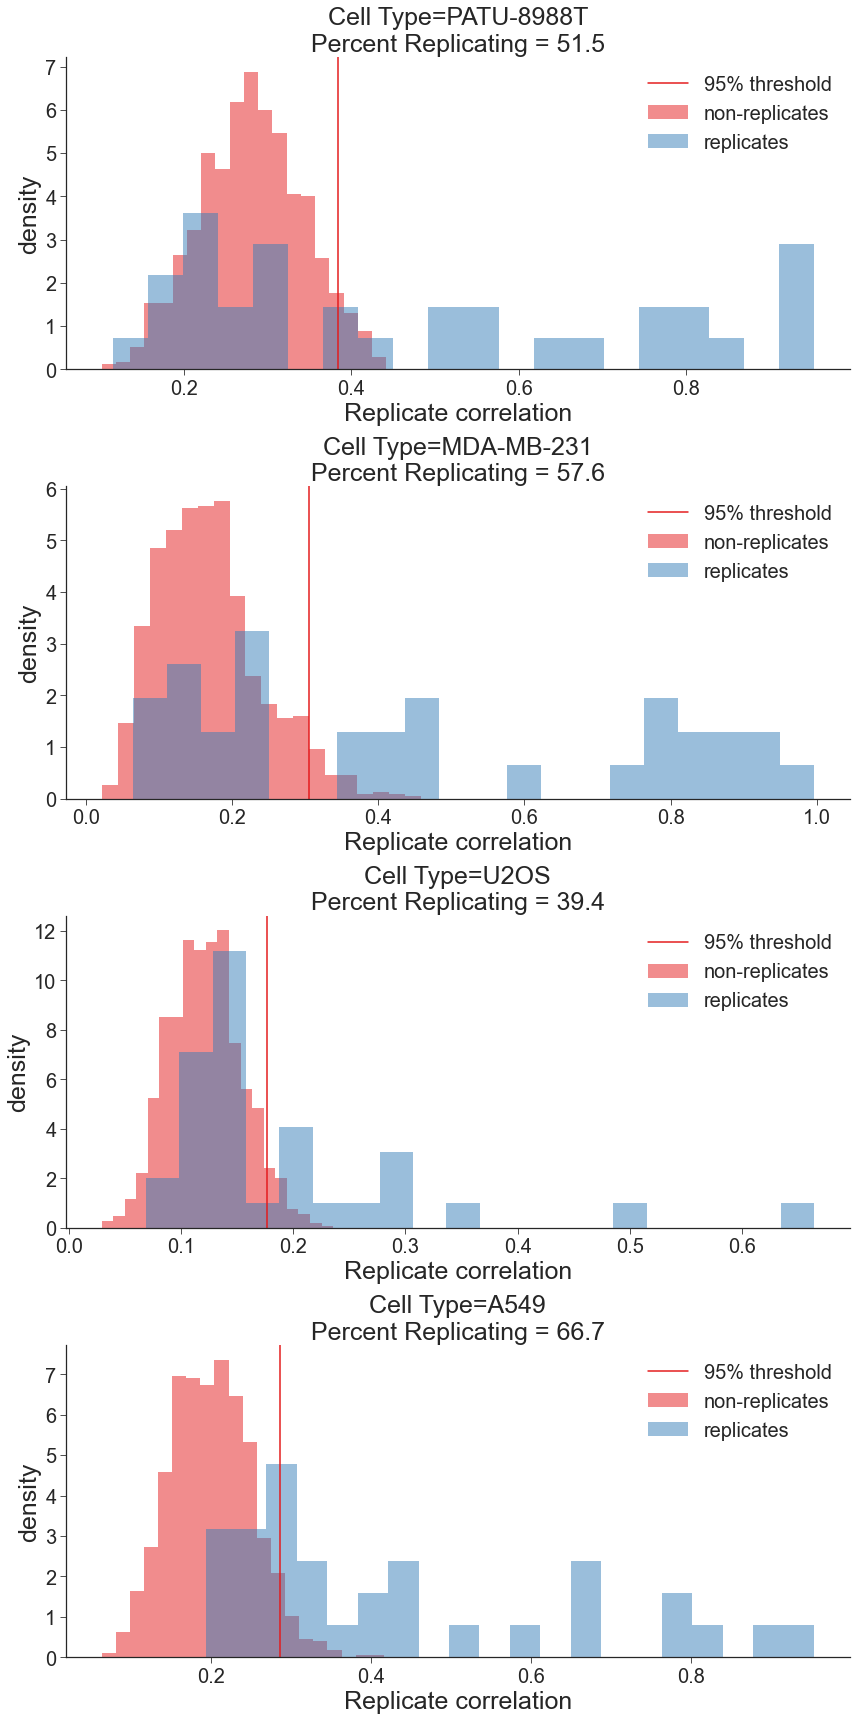

In [5]:
utils.distribution_plot(df=corr_replicating_df, output_file="2.percent_replicating.png", metric="Percent Replicating")

In [6]:
print(corr_replicating_df[['Description', 'Value_95']].to_markdown(index=False))

| Description          |   Value_95 |
|:---------------------|-----------:|
| Cell Type=PATU-8988T |   0.383839 |
| Cell Type=MDA-MB-231 |   0.305252 |
| Cell Type=U2OS       |   0.177008 |
| Cell Type=A549       |   0.285751 |


In [7]:
print(all_replicating_corr_df[['Cell_Type','Metadata_Supplier_Catalog','Concentration','replicate_correlation']].to_markdown(index=False))

| Cell_Type   | Metadata_Supplier_Catalog   |   Concentration |   replicate_correlation |
|:------------|:----------------------------|----------------:|------------------------:|
| PATU-8988T  | AX15836                     |           0.04  |               0.207598  |
| PATU-8988T  | AX15836                     |           0.2   |               0.286918  |
| PATU-8988T  | AX15836                     |           0.4   |               0.311544  |
| PATU-8988T  | BSJ-04-146                  |           0.004 |               0.662566  |
| PATU-8988T  | BSJ-04-146                  |           0.01  |               0.746326  |
| PATU-8988T  | BSJ-04-146                  |           0.04  |               0.788334  |
| PATU-8988T  | BSJ-04-175                  |           0.004 |               0.396165  |
| PATU-8988T  | BSJ-04-175                  |           0.01  |               0.380156  |
| PATU-8988T  | BSJ-04-175                  |           0.04  |               0.500605  |
| PATU-898

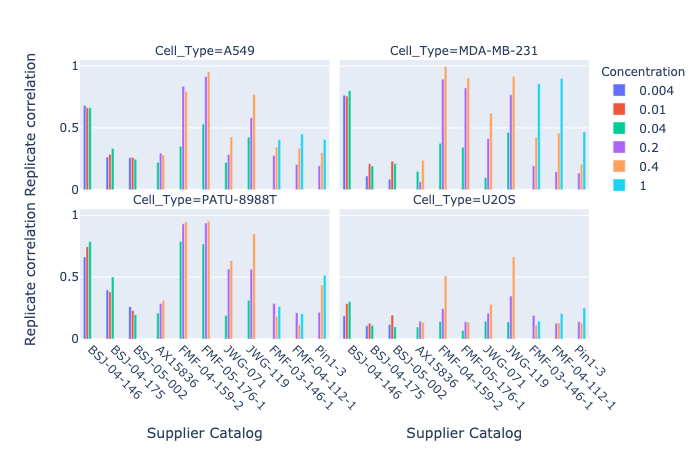

In [8]:
fig = px.bar(data_frame=all_replicating_corr_df.sort_values(by=['Cell_Type', 'Concentration']),
             x='Metadata_Supplier_Catalog',
             y='replicate_correlation',
             color='Concentration',
             barmode='group',
             facet_col='Cell_Type',
             facet_col_wrap=2)
fig.update_xaxes(tickangle=45)
fig.update_layout(bargap=0.3,bargroupgap=0.0,
                  xaxis1=dict(title='Supplier Catalog'),
                  xaxis2=dict(title='Supplier Catalog'),
                  yaxis1=dict(title='Replicate correlation'),
                  yaxis3=dict(title='Replicate correlation'))
fig.show("png")
fig.write_image('figures/2.replicate_correlation_concentration.png', width=800, height=600, scale=2)

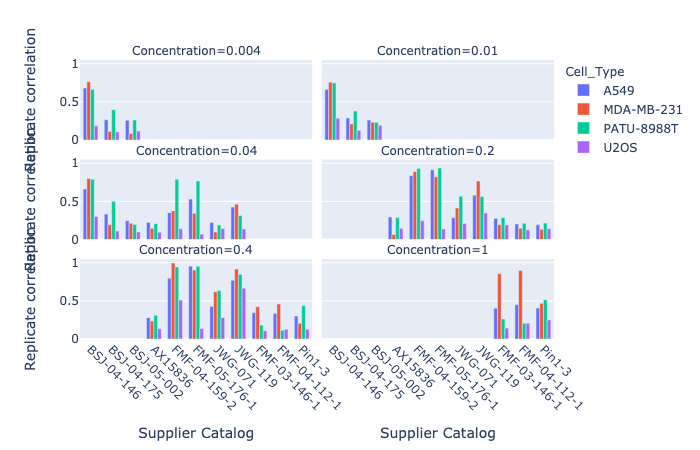

In [9]:
fig = px.bar(data_frame=all_replicating_corr_df.sort_values(by=['Cell_Type', 'Concentration']),
             x='Metadata_Supplier_Catalog',
             y='replicate_correlation',
             color='Cell_Type',
             barmode='group',
             facet_col='Concentration',
             facet_col_wrap=2)
fig.update_xaxes(tickangle=45)
fig.update_layout(bargap=0.3,bargroupgap=0.0,
                  xaxis1=dict(title='Supplier Catalog'),
                  xaxis2=dict(title='Supplier Catalog'),
                  yaxis1=dict(title='Replicate correlation'),
                  yaxis3=dict(title='Replicate correlation'),
                  yaxis5=dict(title='Replicate correlation'))
fig.show("png")
fig.write_image('figures/2.replicate_correlation_cell_type.png', width=800, height=600, scale=2)